**Introduction**

In this competition i was asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

I first use DataBricks but i realized that many models were not implemented and global performance was not good enough. That's why i decided to use a jupyter notebook allowing me to quickly explore much more models.

# Exploration

## Loading packages

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## loading data

In [2]:
train = pd.read_csv('./train-set.csv', index_col=0)

In [4]:
test = pd.read_csv('./test-set.csv', index_col=0)

## data exploration 

In [5]:
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2611,326,20,120,27,1597,168,214,184,2913,...,0,0,0,0,0,0,0,0,0,6
2,2772,324,17,42,7,1814,175,220,183,2879,...,0,0,0,0,0,0,0,0,0,2
3,2764,4,14,480,-21,700,201,212,148,700,...,0,0,0,0,0,0,0,0,0,2
4,3032,342,9,60,8,4050,202,227,164,2376,...,0,0,0,0,0,0,0,0,0,2
5,2488,23,11,117,21,1117,209,218,151,1136,...,0,0,0,0,0,0,0,0,0,2


Any missing data ?

In [6]:
train.columns[train.isnull().any()].tolist()

[]

No!

In [7]:
all(train.dtypes == int)

True

Only integers

## data visualization 

/home/b/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


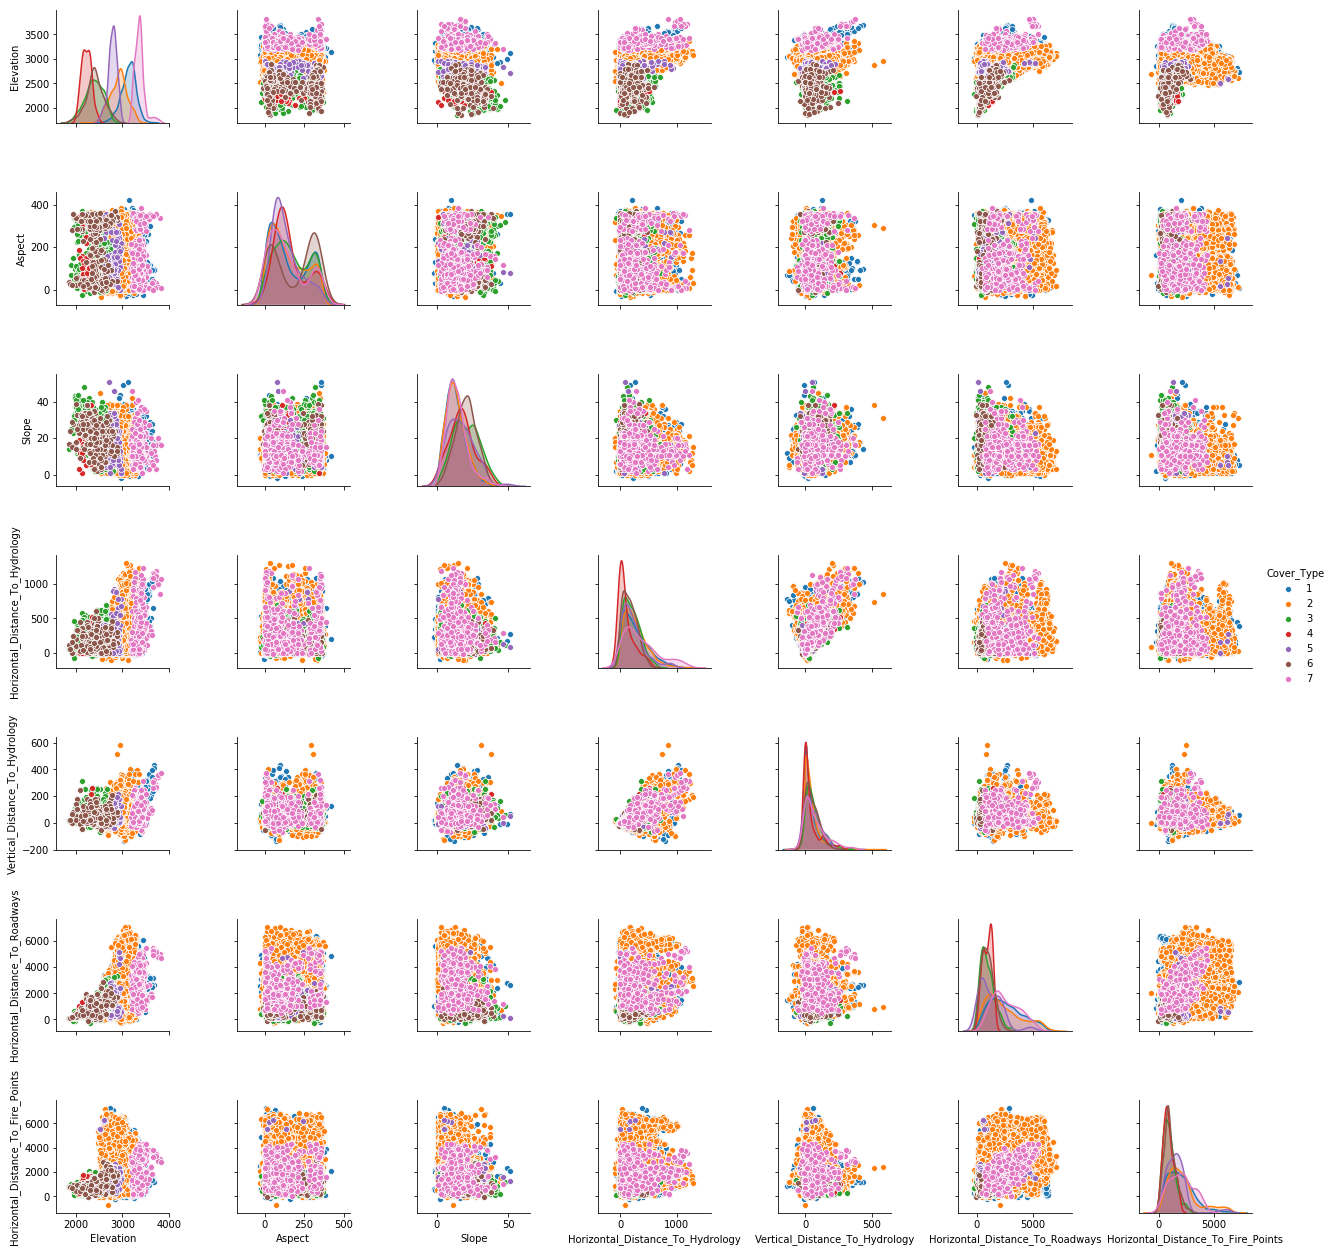

In [16]:
sns.pairplot(train.head(10000), vars=["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
                                      "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points"], hue="Cover_Type")

Then i focus on some correlations which i will use in data engineering parts

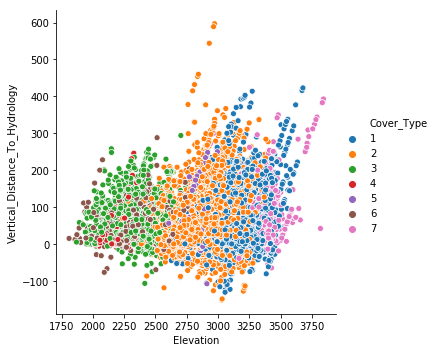

In [99]:
sns.relplot(x="Elevation", y="Vertical_Distance_To_Hydrology", palette=sns.color_palette(
    n_colors=7), hue="Cover_Type", data=train.head(20000))

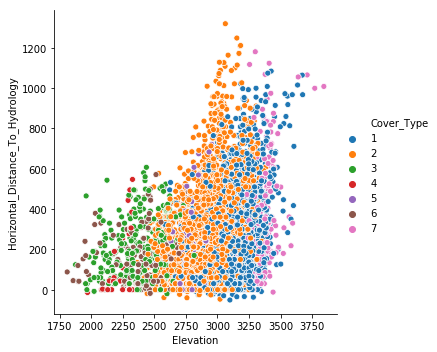

In [111]:
sns.relplot(x="Elevation", y="Horizontal_Distance_To_Hydrology",
            palette=sns.color_palette(n_colors=7), hue="Cover_Type", data=train.head(5000));

# feature engineering

I start building a simple classifier to see how it performs.

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [27]:
train, validation = train_test_split(train)

In [22]:
from sklearn.ensemble import ExtraTreesClassifier

In [30]:
clf = ExtraTreesClassifier(n_estimators = 10, n_jobs=-1)
clf = clf.fit(train.drop(columns="Cover_Type"), train["Cover_Type"] )

In [31]:
cm = confusion_matrix(validation["Cover_Type"] , clf.predict(validation.drop(columns="Cover_Type")))

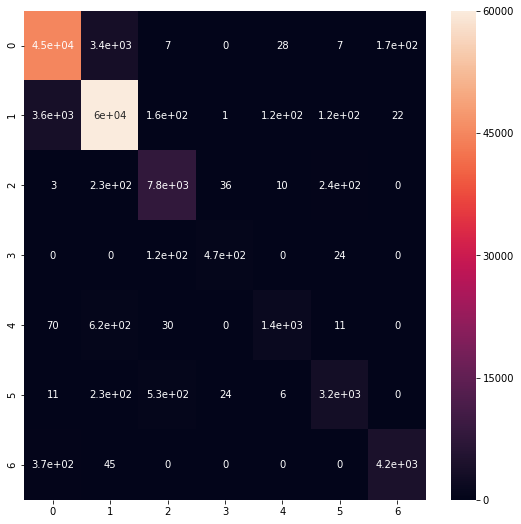

In [33]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True)

Thanks to the confusion matrix we see the misclassified datas. 

In [34]:
data = pd.concat([train,validation, test], sort=False)

Based on intuitions and visualization i add many features.

In [35]:
data['HF1'] = data['Horizontal_Distance_To_Hydrology'] + \
    data['Horizontal_Distance_To_Fire_Points']
data['HF2'] = abs(data['Horizontal_Distance_To_Hydrology'] -
                  data['Horizontal_Distance_To_Fire_Points'])
data['HR1'] = abs(data['Horizontal_Distance_To_Hydrology'] +
                  data['Horizontal_Distance_To_Roadways'])
data['HR2'] = abs(data['Horizontal_Distance_To_Hydrology'] -
                  data['Horizontal_Distance_To_Roadways'])
data['FR1'] = abs(data['Horizontal_Distance_To_Fire_Points'] +
                  data['Horizontal_Distance_To_Roadways'])
data['FR2'] = abs(data['Horizontal_Distance_To_Fire_Points'] -
                  data['Horizontal_Distance_To_Roadways'])
data['EVDtH'] = data.Elevation-data.Vertical_Distance_To_Hydrology
data['EHDtH'] = data.Elevation-data.Horizontal_Distance_To_Hydrology*0.2
data['Hydro_slope'] = data.Vertical_Distance_To_Hydrology / \
    data.Horizontal_Distance_To_Hydrology
data['Fire_v'] = data.Slope*data.Horizontal_Distance_To_Fire_Points


data['dist_hyd'] = (data['Horizontal_Distance_To_Hydrology']
                    ** 2+data['Vertical_Distance_To_Hydrology']**2)**0.5
data = data.replace([np.inf, -np.inf, None], 0)
# Mean distance to Amenities
data['Mean_Amenities'] = (data.Horizontal_Distance_To_Fire_Points +
                          data.Horizontal_Distance_To_Hydrology + data.Horizontal_Distance_To_Roadways) / 3
# Mean Distance to Fire and Water
data['Mean_Fire_Hyd'] = (data.Horizontal_Distance_To_Fire_Points +
                         data.Horizontal_Distance_To_Hydrology) / 2

# Min distance to Amenities
data['Min_Amenities'] = data[["Horizontal_Distance_To_Fire_Points",
                              "Horizontal_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways"]].min(axis=1)
# Min Distance to Fire and Water
data['Min_Fire_Hyd'] = data[["Horizontal_Distance_To_Fire_Points",
                             "Horizontal_Distance_To_Hydrology"]].min(axis=1)

I try a lot of things to improve my model including PCA, robust scaler, different models (xgboost, random forest, multilayer perceptron...)

In [6]:
from sklearn.decomposition import PCA

In [42]:
pca = PCA(n_components=40)

In [14]:
data_pca = pca.fit_transform(data.drop(columns='Cover_Type'))

In [18]:
train_pca, test_pca = np.split(data_pca, [528720])

In [22]:
y_train = train['Cover_Type']

# model construction

Finally i try to improve my models testing a lot of differents parameters. My best result was achieved with an ExtraTreesClassifier with 300 estimators performing a pretty good 0.96 score on test set.

In [26]:
clf = ExtraTreesClassifier(n_estimators=300)
clf = clf.fit(train_pca, y_train)

In [27]:
test['Cover_Type'] = clf.predict(test_pca).astype(int)

In [28]:
test[['Cover_Type']].to_csv("./PCA_n300")